# Predicting Survival on the Titanic

Variable Definition Key

survival Survival 0 = No, 1 = Yes

pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Sex 

Age: Age in years

sibsp nb of siblings / spouses aboard the Titanic

parch nb of parents / children aboard the Titanic

ticket : Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age 

sibsp: The dataset defines family relations in this way,
Sibling = brother, sister, stepbrother, stepsister,
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way,
Parent = mother, father,
Child = daughter, son, stepdaughter, stepson,
Some children travelled only with a nanny, therefore parch=0 for them.

In [134]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
import joblib
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [135]:
data = pd.read_csv(r'C:\Users\nico_\Desktop\mlops_udemy\Titanic\Titanic-Dataset.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [137]:
# drop unnecessary variables

data.drop(labels=['PassengerId','Name','Ticket'], axis=1, inplace=True)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [138]:
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Numerical and categorical variables

In [139]:
target = 'Survived'

In [140]:
vars_num = [c for c in data.columns if data[c].dtypes!='O' and c!=target]

vars_cat = [c for c in data.columns if data[c].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 3


### Missing values in variables

In [141]:
# numerical variables
data[vars_num].isnull().mean()

Pclass    0.000000
Age       0.198653
SibSp     0.000000
Parch     0.000000
Fare      0.000000
dtype: float64

In [142]:
# categorical variables
data[vars_cat].isnull().mean()

Sex         0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

### Cardinality of categorical variables

In [143]:
data[vars_cat].nunique()

Sex           2
Cabin       147
Embarked      3
dtype: int64

### Distribution of numerical variables

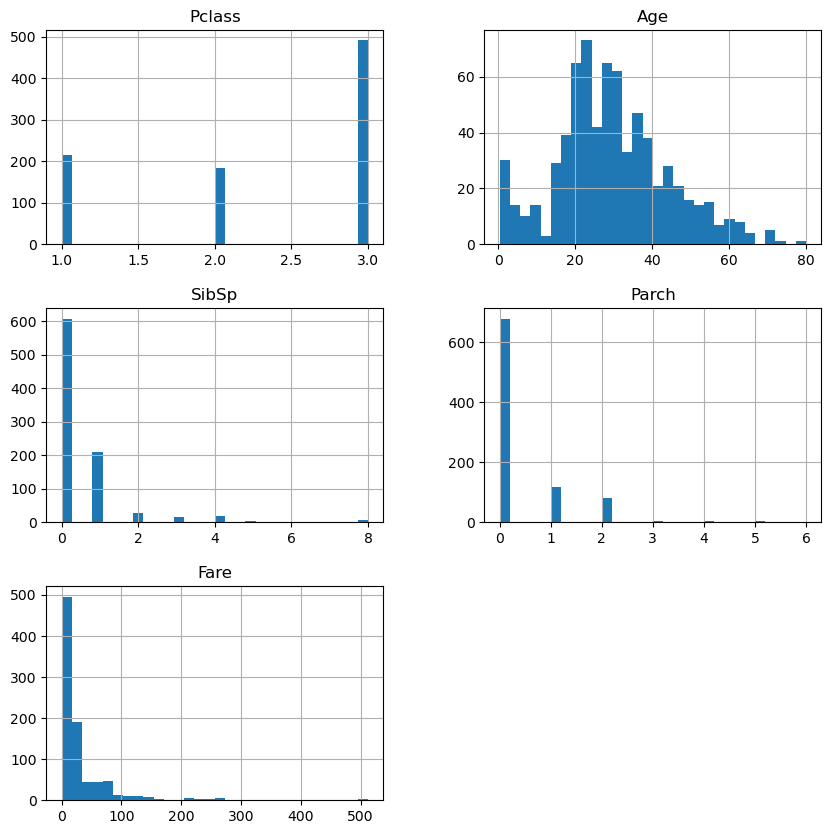

In [144]:
data[vars_num].hist(bins=30, figsize=(10,10))
plt.show()

## Train and test sets

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  
    data['Survived'],  
    test_size=0.2,  
    random_state=0)  

X_train.shape, X_test.shape

((712, 8), (179, 8))

## Feature Engineering

### Extraction of the letter from the variable Cabin

In [146]:
X_train['Cabin'] = X_train['Cabin'].str[0]
X_test['Cabin'] = X_test['Cabin'].str[0]

X_train['Cabin'].unique()

array([nan, 'C', 'B', 'A', 'G', 'E', 'D', 'F', 'T'], dtype=object)

### Missing data in numerical variables:

In [147]:
median = X_train['Age'].median()
X_train['Age'].fillna(median, inplace=True)
X_test['Age'].fillna(median, inplace=True)

In [148]:
X_train['Age'].isna().sum()

0

In [149]:
X_test['Age'].isna().sum()

0

### Missing data in categorical variables with the string **Missing**

In [150]:
# Cabin Embarked
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [151]:
X_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [152]:
X_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

### One hot encoding of categorical variables 

In [153]:
X_train[vars_cat].nunique()

Sex         2
Cabin       9
Embarked    4
dtype: int64

In [154]:
X_train = pd.concat([X_train, pd.get_dummies(X_train[vars_cat], prefix=vars_cat, drop_first=True)], axis=1)
# drop_first=TRue -> permet de supprimer la colinéarité en éliminant la redondance de la somme des 3 colonnes
X_test = pd.concat([X_test, pd.get_dummies(X_test[vars_cat], prefix=vars_cat, drop_first=True)], axis=1)

X_train.drop(labels=vars_cat, axis=1, inplace=True)

X_test.drop(labels=vars_cat, axis=1, inplace=True)

In [155]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_Missing,Cabin_T,Embarked_Missing,Embarked_Q,Embarked_S
140,3,29.0,0,2,15.2458,False,False,False,False,False,False,False,True,False,False,False,False
439,2,31.0,0,0,10.5000,True,False,False,False,False,False,False,True,False,False,False,True
817,2,31.0,1,1,37.0042,True,False,False,False,False,False,False,True,False,False,False,False
378,3,20.0,0,0,4.0125,True,False,False,False,False,False,False,True,False,False,False,False
491,3,21.0,0,0,7.2500,True,False,False,False,False,False,False,True,False,False,False,True


In [156]:
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_Missing,Embarked_Q,Embarked_S
495,3,29.0,0,0,14.4583,True,False,False,False,False,False,True,False,False
648,3,29.0,0,0,7.5500,True,False,False,False,False,False,True,False,True
278,3,7.0,4,1,29.1250,True,False,False,False,False,False,True,True,False
31,1,29.0,1,0,146.5208,False,False,False,False,False,False,False,False,False
255,3,29.0,0,2,15.2458,False,False,False,False,False,False,True,False,False


In [157]:
print(X_train.shape)
print(X_test.shape)

(712, 17)
(179, 14)


We have three columns less in the test set : Cabin_B, Cabin_T, Embarked_Missing. We have to create these columns.

In [158]:
X_test["Cabin_B"] = 0
X_test["Cabin_T"] = 0
X_test["Embarked_Missing"] = 0

In [159]:
print(X_train.shape)
print(X_test.shape)

(712, 17)
(179, 17)


In [160]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_Missing',
       'Cabin_T', 'Embarked_Missing', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [120]:
X_test.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_Missing',
       'Embarked_Q', 'Embarked_S', 'Cabin_T', 'Embarked_Missing'],
      dtype='object')

In [161]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [162]:
variables = [c  for c in X_train.columns]

variables

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_male',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_Missing',
 'Cabin_T',
 'Embarked_Missing',
 'Embarked_Q',
 'Embarked_S']

### Scaling the variables

In [163]:
scaler = StandardScaler()
scaler.fit(X_train[variables])

X_train = scaler.transform(X_train[variables])
X_test = scaler.transform(X_test[variables])

## Train the Logistic Regression model

In [211]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Predictions and evaluations of model performance

In [212]:
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train, y_train_proba)
accuracy = accuracy_score(y_train, y_train_pred)

print('Train ROC-AUC: ',  roc_auc)
print('Train Accuracy: ', accuracy)

Train ROC-AUC:  0.8611354476958122
Train Accuracy:  0.8047752808988764


In [213]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)

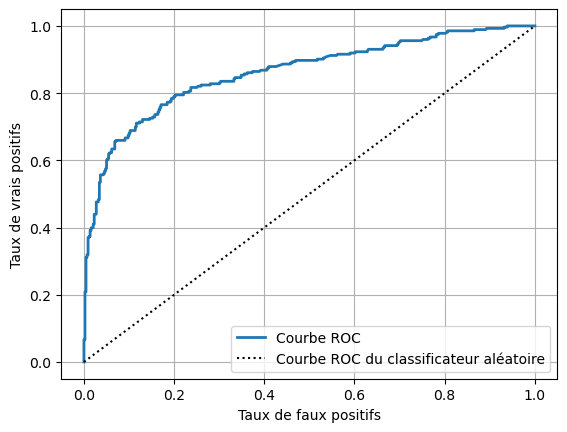

In [214]:
plt.plot(fpr,tpr,linewidth=2, label="Courbe ROC")
plt.plot([0,1], [0,1], "k:", label="Courbe ROC du classificateur aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()

In [215]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_test_proba)
accuracy = accuracy_score(y_test, y_test_pred)

print('Test ROC-AUC: ',  roc_auc)
print('Test Accuracy: ', accuracy)

Test ROC-AUC:  0.869433465085639
Test Accuracy:  0.8156424581005587


In [216]:
fpr, tpr, thresholds = roc_curve(y_test, pred)

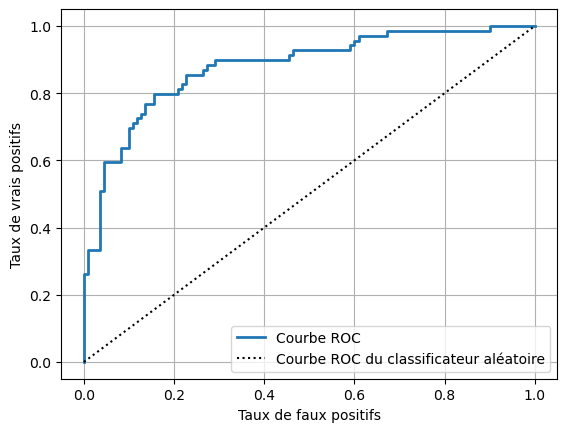

In [217]:
plt.plot(fpr,tpr,linewidth=2, label="Courbe ROC")
plt.plot([0,1], [0,1], "k:", label="Courbe ROC du classificateur aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()

The AUC Score and the accuracy score demonstrate good performance of the model